## Generate a mock data set based on method outlined in Rubin et al 2015

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [47]:
import numpy as np
import matplotlib.pylab as plt
import sncosmo
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import scipy.stats as stats

Create 4 data sets in ranges:

0.02 - 0.05 : N = 250, zp uncertainty = 0.01 mag

0.05 - 0.4  : N = 250, zp uncertainty = 0.01 mag

0.2  - 1.0  : N = 250, zp uncertainty = 0.01 mag

0.7  - 1.4  : N = 50,  zp uncertainty = 0.02 mag


x1: unit normal distribution centered on zero

c : sum of Gaussian distribution with width 0.1 mag and an exponential function with rate 1/0.1 mag. Centered on zero

uncertainties (Gaussian independent): 

0.05 mB, 0.5 x1, 0.05 c, 0.1 mag unexplained, 0.093z mag of lensing dispersion, 300 km/s peculiar velocity
zeropoint uncertainties: 0.01, 0.01, 0.01, 0.02 

alpha = 0.13, beta = 3.0, MB = -19.1 mag, Omega_M = 0.3 (flat LCDM)

delta(0) = 0.08 mag

delta(inf)/delta(0) : uniform distribution between 0 and 1

Assume 3 percent are outliers. Draw their observed distribution centered around the normal Ia mB for that redshift. and around zero in x1 and c. The spread is 1,2, and 0.5 in mB,x1, and c. Assume distributions are Gaussian and uncorrelated

Selection effects in mB with width 0.2 mag. 
Selection cus are chosen for 50% completeness at z = 0.08, 0.25, 0.6, 1.45 .
Randomly draw from the population distributions an dpass them throug the simulated selection effects until required number of SNe are gnerated

Redshift distribution of SNe scales linearly wiht redshift starting form the minimum redshift of each sample


mu_Bi^obs = m_Bi^obs + alpha * x_1i^obs - beta * c_i^obs + delta(M_star > 10^10) - M_B


In [3]:
alpha   = 0.13
beta    = 3.0
M_B     = -19.1
Omega_M = 0.3

delta_zero = 0.08 #mag

cosmo = FlatLambdaCDM(H0=70, Om0=Omega_M)

In [4]:
## Define Constant mass-standardization

def delta(z):
    delta_inf_over_zero = stats.uniform.rvs(loc=0, scale=1, size = 1)
    return delta_zero * ( 1.9*(1.0 - delta_inf_over_zero )/(0.9 + 10.0**(0.95*z)) + delta_inf_over_zero)  


In [5]:
# x1 distribution
#x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1000)

In [6]:
## c distribution
#  K=1/σλ = 1/(0.1/0.1) = 1

#c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1000)

In [7]:
## mB

def mB_center(z):
    return 5.0*np.log10(cosmo.luminosity_distance(z).value / 10.**(-5.) ) + M_B

#mB = stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1000)
    

In [8]:
# uncertainties

sigma_mB = 0.05
sigma_x1 = 0.5
sigma_c  = 0.05
sigma_unexplained = 0.1 #mag

def sigma_lens(z):
    return 0.093*z # mag

sigma_PV = 300 #km/s

sigma_zp = np.array([0.01, 0.01, 0.01, 0.02])

In [9]:
# 3 % outliers

#mB_out = stats.norm.rvs(loc = mB_center(z), scale = 1.0,  size=1000*0.03)
#x1_out = stats.norm.rvs(loc = 0.0,   scale = 2.0,  size=1000*0.03)
#c_out  = stats.norm.rvs(loc = 0.0,   scale = 0.5,  size=1000*0.03)

In [10]:
# redshift distributions
## not correct

class linear_gen(stats.rv_continuous):
    "Linear distribution"
    def _pdf(self, x, z0, z1):
        m = 1.0 / (0.5*(z1*z1-z0*z0)-z0*(z1-z0))
        c = - m * z0
        return m*x + c #(x-a)/(b-a) #k*x + m


In [11]:
#class erflike_gen(stats.rv_continuous):
#    "Erf-like distribution"
#    def _pdf(self, x, z_cent): 
#        f = lambda x : (stats.norm.sf(x, loc=z_cent, scale=0.2))
#        y,err = quad(f, 0, np.inf)
#        return (1./y)*(stats.norm.sf(x, loc=z_cent, scale=0.2)) #(x-a)/(b-a) #k*x + m

In [12]:
#class erflin_gen(stats.rv_continuous):
#    "Erf-like plus linear distribution"
#    def _pdf(self, x, z_cent, z0, z1): 
#        m = 1.0 / (0.5*(z1*z1-z0*z0)-z0*(z1-z0))
#        c = - m * z0
#        #return m*x + b
#        #f = lambda x : (stats.norm.sf(x, loc=z_cent, scale=0.2)*( m*x + b) )
#        #y,err = quad(f, 0, np.inf)
#        return (1./2.7753780074995613)*(stats.norm.sf(x, loc=z_cent, scale=0.2)) * ( m*x + c)  #(x-a)/(b-a) #k*x + m

In [13]:
linearlow= linear_gen(name='linear', a =0.02, b = 0.05 )
linearmedlow= linear_gen(name='linear', a =0.05, b = 0.4 )
linearmedhigh= linear_gen(name='linear', a =0.2, b = 1. )
linearhigh= linear_gen(name='linear', a =0.7, b = 1.4 )

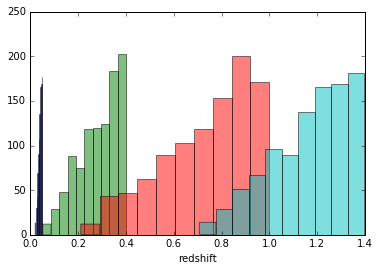

In [44]:
plt.hist(linearlow.rvs(z0 = 0.02, z1 = 0.05,size = 1000), alpha = 0.5)  
plt.hist(linearmedlow.rvs(z0 = 0.05, z1 = 0.4,size = 1000), alpha = 0.5)  
plt.hist(linearmedhigh.rvs(z0 = 0.2, z1 = 1.,size = 1000), alpha = 0.5) 
#linearmedhigh.rvs(a = 0.2, b = 1.,size = 100)
plt.hist(linearhigh.rvs(z0 = 0.7, z1 = 1.4,size = 1000), alpha = 0.5)  
plt.xlabel('redshift')
plt.savefig('linear_redshifts.png')

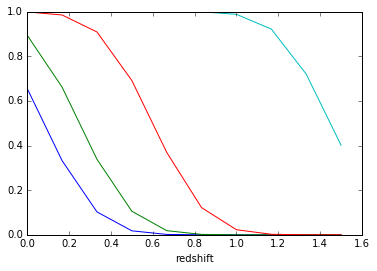

In [45]:
plt.plot(np.linspace(0,1.5,10),stats.norm.sf(np.linspace(0,1.5,10), loc=0.08, scale=0.2))#0.08, 0.25, 0.6, 1.45 
plt.plot(np.linspace(0,1.5,10),stats.norm.sf(np.linspace(0,1.5,10), loc=0.25, scale=0.2))
plt.plot(np.linspace(0,1.5,10),stats.norm.sf(np.linspace(0,1.5,10), loc=0.6, scale=0.2))
plt.plot(np.linspace(0,1.5,10), stats.norm.sf(np.linspace(0,1.5,10), loc=1.45, scale=0.2))
plt.xlabel('redshift')
plt.savefig('completeness.png')

In [25]:
low_z = []
z_tot = []
while len(low_z) < 250 :
    z = linearlow.rvs(z0 = 0.02, z1 = 0.05,size = 1)
    z_tot.append(z[0])
    if stats.uniform.rvs(size=1)<stats.norm.sf(z[0], loc=0.08, scale=0.2):
        delta_per_SN = delta(z)
        if stats.uniform.rvs(size=1)>0.03:
            mB = mB_center(z) #stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1)
            x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1)
            c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1)
        else:
            mB = stats.norm.rvs(loc = mB_center(z), scale = 1,  size=1)
            x1 = stats.norm.rvs(loc = 0.0, scale = 2,  size=1)
            c  = stats.norm.rvs(loc = 0.0, scale = 0.5,  size=1)
        low_z.append([mB[0], x1[0], c[0], delta_per_SN[0], z])

In [26]:
medlow_z = []
z_tot_ml = []
while len(medlow_z) < 250 :
    z = linearmedlow.rvs(z0 = 0.05, z1 = 0.4,size = 1)
    z_tot_ml.append(z[0])
    if stats.uniform.rvs(size=1)<stats.norm.sf(z[0], loc=0.25, scale=0.2):
        delta_per_SN = delta(z)
        if stats.uniform.rvs(size=1)>0.03:
            mB = mB_center(z) #stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1)
            x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1)
            c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1)
        else:
            mB = stats.norm.rvs(loc = mB_center(z), scale = 1,  size=1)
            x1 = stats.norm.rvs(loc = 0.0, scale = 2,  size=1)
            c  = stats.norm.rvs(loc = 0.0, scale = 0.5,  size=1)
        medlow_z.append([mB[0], x1[0], c[0], delta_per_SN[0], z])

In [27]:
medhigh_z = []
z_tot_mh = []
while len(medhigh_z) < 250 :
    z = linearmedhigh.rvs(z0 = 0.2, z1 = 1.,size = 1)
    z_tot_mh.append(z[0])
    if stats.uniform.rvs(size=1)<stats.norm.sf(z[0], loc=0.6, scale=0.2):
        delta_per_SN = delta(z)
        if stats.uniform.rvs(size=1)>0.03:
            mB = mB_center(z) #stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1)
            x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1)
            c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1)
        else:
            mB = stats.norm.rvs(loc = mB_center(z), scale = 1,  size=1)
            x1 = stats.norm.rvs(loc = 0.0, scale = 2,  size=1)
            c  = stats.norm.rvs(loc = 0.0, scale = 0.5,  size=1)
        medhigh_z.append([mB[0], x1[0], c[0], delta_per_SN[0], z])

In [30]:
high_z = []
z_tot_high = []
while len(high_z) < 50 :
    z = linearhigh.rvs(z0 = 0.7, z1 = 1.4,size = 1)
    z_tot_high.append(z[0])
    if stats.uniform.rvs(size=1)<stats.norm.sf(z[0], loc=1.45, scale=0.2):
        delta_per_SN = delta(z)
        if stats.uniform.rvs(size=1)>0.03:
            mB = mB_center(z) #stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1)
            x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1)
            c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1)
        else:
            mB = stats.norm.rvs(loc = mB_center(z), scale = 1,  size=1)
            x1 = stats.norm.rvs(loc = 0.0, scale = 2,  size=1)
            c  = stats.norm.rvs(loc = 0.0, scale = 0.5,  size=1)
        high_z.append([mB[0], x1[0], c[0], delta_per_SN[0], z])
        

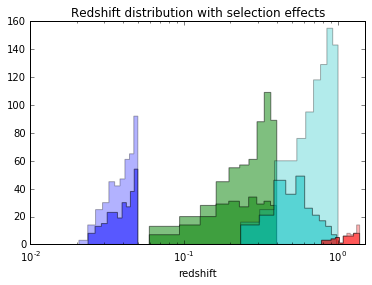

In [43]:
plt.hist(z_tot, alpha = 0.3, color = 'b',  histtype='stepfilled')
plt.hist(np.array(low_z)[:,-1], alpha = 0.5, color = 'b',  histtype='stepfilled')

plt.hist(z_tot_ml, alpha = 0.5, color = 'g',  histtype='stepfilled')
plt.hist(np.array(medlow_z)[:,-1], alpha = 0.5, color = 'g',  histtype='stepfilled')

plt.hist(z_tot_mh, alpha = 0.3, color = 'c',  histtype='stepfilled')
plt.hist(np.array(medhigh_z)[:,-1], alpha = 0.5, color = 'c',  histtype='stepfilled')

plt.hist(z_tot_high, alpha = 0.3, color = 'r',  histtype='stepfilled')
plt.hist(np.array(high_z)[:,-1], alpha = 0.5, color = 'r',  histtype='stepfilled')

plt.xscale('log') 
plt.xlim(0.01,1.5 )
plt.xlabel('redshift')
plt.title('Redshift distribution with selection effects')
#plt.savefig('redshift_selection.png')

(-1, 0.8)

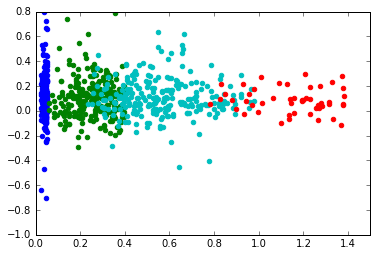

In [42]:
plt.scatter(np.array(low_z)[:,-1],np.array(low_z)[:,2], color = 'b')
plt.scatter(np.array(medlow_z)[:,-1],np.array(medlow_z)[:,2], color = 'g')
plt.scatter(np.array(medhigh_z)[:,-1],np.array(medhigh_z)[:,2], color = 'c')
plt.scatter(np.array(high_z)[:,-1],np.array(high_z)[:,2], color = 'r')

plt.xlim(0,1.5)
plt.ylim(-1,0.8)

In [62]:
names = ['m_B', 'x1', 'c', 'z', 'delta', 'm_B_err', 'x1_err', 'c_err','unexplained_err','lensing_err', 'zp_err', 'peculiar_vel']
#0.05 mB, 0.5 x1, 0.05 c, 0.1 mag unexplained, 0.093z mag of lensing dispersion, 300 km/s peculiar velocity zeropoint uncertainties: 0.01, 0.01, 0.01, 0.02
def make_data():
    low_z = []
    z_tot = []
    while len(low_z) < 250 :
        z = linearlow.rvs(z0 = 0.02, z1 = 0.05,size = 1)
        z_tot.append(z[0])
        if stats.uniform.rvs(size=1)<stats.norm.sf(z[0], loc=0.08, scale=0.2):
            if stats.uniform.rvs(size=1)>0.03:
                mB = mB_center(z) #stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1)
                x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1)
                c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1)
            else:
                mB = stats.norm.rvs(loc = mB_center(z), scale = 1,  size=1)
                x1 = stats.norm.rvs(loc = 0.0, scale = 2,  size=1)
                c  = stats.norm.rvs(loc = 0.0, scale = 0.5,  size=1)
            delta_per_SN = delta(z)
            low_z.append([mB[0], x1[0], c[0], z, delta_per_SN[0],0.5,0.5,0.05,0.1, sigma_lens(z[0]), 0.01,300.])
    medlow_z = []
    z_tot_ml = []
    while len(medlow_z) < 250 :
        z = linearmedlow.rvs(z0 = 0.05, z1 = 0.4,size = 1)
        z_tot_ml.append(z[0])
        if stats.uniform.rvs(size=1)<stats.norm.sf(z[0], loc=0.25, scale=0.2):
            delta_per_SN = delta(z)
            if stats.uniform.rvs(size=1)>0.03:
                mB = mB_center(z) #stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1)
                x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1)
                c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1)
            else:
                mB = stats.norm.rvs(loc = mB_center(z), scale = 1,  size=1)
                x1 = stats.norm.rvs(loc = 0.0, scale = 2,  size=1)
                c  = stats.norm.rvs(loc = 0.0, scale = 0.5,  size=1)
        medlow_z.append([mB[0], x1[0], c[0], z, delta_per_SN[0],0.5,0.5,0.05,0.1, sigma_lens(z[0]), 0.01,300.])
    medhigh_z = []
    z_tot_mh = []
    while len(medhigh_z) < 250 :
        z = linearmedhigh.rvs(z0 = 0.2, z1 = 1.,size = 1)
        z_tot_mh.append(z[0])
        if stats.uniform.rvs(size=1)<stats.norm.sf(z[0], loc=0.6, scale=0.2):
            delta_per_SN = delta(z)
            if stats.uniform.rvs(size=1)>0.03:
                mB = mB_center(z) #stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1)
                x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1)
                c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1)
            else:
                mB = stats.norm.rvs(loc = mB_center(z), scale = 1,  size=1)
                x1 = stats.norm.rvs(loc = 0.0, scale = 2,  size=1)
                c  = stats.norm.rvs(loc = 0.0, scale = 0.5,  size=1)
            medhigh_z.append([mB[0], x1[0], c[0], z, delta_per_SN[0],0.5,0.5,0.05,0.1, sigma_lens(z[0]), 0.01,300.])
    high_z = []
    z_tot_high = []
    while len(high_z) < 50 :
        z = linearhigh.rvs(z0 = 0.7, z1 = 1.4,size = 1)
        z_tot_high.append(z[0])
        if stats.uniform.rvs(size=1)<stats.norm.sf(z[0], loc=1.45, scale=0.2):
            delta_per_SN = delta(z)
            if stats.uniform.rvs(size=1)>0.03:
                mB = mB_center(z) #stats.norm.rvs(loc = mB_center(z), scale = 0.20,  size=1)
                x1 = stats.norm.rvs(loc = 0.0, scale = 0.1,  size=1)
                c = stats.exponnorm.rvs(loc = 0.0, scale = 0.1, K = 1.0, size=1)
            else:
                mB = stats.norm.rvs(loc = mB_center(z), scale = 1,  size=1)
                x1 = stats.norm.rvs(loc = 0.0, scale = 2,  size=1)
                c  = stats.norm.rvs(loc = 0.0, scale = 0.5,  size=1)
            high_z.append([mB[0], x1[0], c[0], z, delta_per_SN[0],0.5,0.5,0.05,0.1, sigma_lens(z[0]), 0.02,300.])
    t = Table(np.array(low_z + medlow_z + medhigh_z +high_z), names = names)
    return t

In [65]:
t = make_data()

In [70]:
for i in range(30):
    t = make_data()
    t.write('../mock_data/dataset_%s.dat'%i, format='ascii')